In [61]:
import config, parse_midas_data, sample_utils as su, temporal_changes_utils, stats_utils, midas_db_utils, parse_patric
from collections import defaultdict
import numpy as np
from numpy.random import binomial as sample_binomial
import math
import pickle
import sys
import random
from math import log10,ceil,log,exp

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# Cohort list
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Sample-subject-order maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
same_mi_pair_dict = su.get_same_mi_pair_dict(subject_sample_map)
sys.stderr.write("Done!\n")

# Timepoint pair types
tp_pair_names = ['MM', 'MI', 'II', 'AA']

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')

# Sample-cohort map
sample_cohort_map = su.parse_sample_cohort_map()

# Sample-timepoint map
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts=['olm']) # no binning
mi_tp_sample_dict_binned, mi_tp_binned_labels = su.get_mi_tp_sample_dict(exclude_cohorts=['olm'], binned=True)

# Narrow down samples to no Olm, and mother only at delivery
# (Exception made for Backhed, since )
infant_samples = [sample for sample in infant_samples if sample not in olm_samples]
mother_samples = [sample for sample in mother_samples if (mi_sample_day_dict[sample] <= 30 and mi_sample_day_dict[sample] > -7)]
mi_samples = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

Loading sample metadata...
Done!


In [47]:
# Distribution of mother sample timepoints
# To decide which ones to exclude

day_count_dict = defaultdict(int)

for sample in su.get_sample_names('mother'):
    day = mi_sample_day_dict[sample]
    day_count_dict[day] += 1

for day in day_count_dict:
    print("Day %i:\t%i mother samples" % (day, day_count_dict[day]))

Day 0:	92 mother samples
Day 1:	180 mother samples
Day 2:	17 mother samples
Day 3:	12 mother samples
Day 4:	10 mother samples
Day 5:	5 mother samples
Day 6:	5 mother samples
Day 7:	3 mother samples
Day 8:	5 mother samples
Day 9:	1 mother samples
Day 10:	2 mother samples
Day 11:	2 mother samples
Day 12:	2 mother samples
Day 20:	1 mother samples
Day -92:	42 mother samples
Day 92:	31 mother samples


In [48]:
# Qin metadata
f = open('%s/qin_ids.txt' % config.metadata_directory)
header = f.readline()

qin_subjects = set()
qin_samples = set()
qin_subject_sample_map = defaultdict(list)

for line in f:
    subject_id, sample_id, run_accession, country, continent, t2d = line.strip().split('\t')
    qin_subjects.add(subject_id)
    qin_samples.add(run_accession)
    qin_subject_sample_map[subject_id].append(run_accession)
    sample_cohort_map[run_accession] = 'qin' # Update sample_cohort_map

print("Qin: %i subjects, %i samples" % (len(qin_subjects), len(qin_samples)))
print("# samples per subject: %s" % str(set([len(subject_sample_map[subj]) for subj in subject_sample_map])))

Qin: 185 subjects, 185 samples
# samples per subject: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])


In [49]:
# EVERY SAMPLE CONSIDERED IN THIS STUDY

all_samples = list(mi_samples) + list(hmp_samples) + list(qin_samples)

print("%i total samples from all cohorts" % len(all_samples))

# Make subject_cohort_map
subject_cohort_map = {}
# Combine mother infant as same subject
mi_subject_cohort_map = {}
cohort_subjects = defaultdict(list)

for subject in subject_sample_map: # Includes Qin
    for some_sample in subject_sample_map[subject]:
        if some_sample in all_samples:
            cohort = sample_cohort_map[some_sample]
            subject_cohort_map[subject] = cohort
        else:
            continue

        if some_sample in mi_samples:
            combined_subject = subject[:-2]
            mi_subject_cohort_map[combined_subject] = cohort
        else:
            mi_subject_cohort_map[subject] = cohort

for subject in mi_subject_cohort_map:
    cohort = mi_subject_cohort_map[subject]
    cohort_subjects[cohort].append(subject)

print("Total number of mother-infant subjects (excludes Qin): %i" % len(mi_subject_cohort_map))

# EVERY SUBJECT
all_subjects = list(qin_subjects) + list(set([(sample_subject_map[sample]) for sample in all_samples if sample not in qin_samples]))

print("Total number of subjects: %i" % (len(all_subjects)))

3053 total samples from all cohorts
Total number of mother-infant subjects (excludes Qin): 1016
Total number of subjects: 1533


In [50]:
# NOTE: there are 4 Shao subjects that ONLY have one mother sample.
# Not counting these in number of hosts in Table 1.

# Also, there is 1 Yassour subject that has ONLY one mother sample
# (when mother is restricted to delivery). Also not counting this host.
for cohort in cohort_subjects:
    print("%s: %i subjects" % (cohort, len(set(cohort_subjects[cohort]))))

yassour: 44 subjects
ferretti: 25 subjects
hmp: 249 subjects
shao: 600 subjects
backhed: 98 subjects


In [51]:
# Subjects per broad type
subjects_count = {'mother': set(), 'infant': set(), 'adult': set()}

# Subjects per cohort (infant)
cohorts_count = defaultdict(set)

# Subjects per cohort (mother)
cohorts_mother_count = defaultdict(set)

# Samples per cohort (combine mother and infant)
samples_cohort_count = defaultdict(int)

for sample in sample_subject_map:
    subject = sample_subject_map[sample]
    if sample in mother_samples:
        x = 'mother'
        cohort = sample_cohort_map[sample]
        cohorts_mother_count[cohort].add(subject)
        samples_cohort_count[cohort] += 1
    elif sample in infant_samples:
        x = 'infant'
        cohort = sample_cohort_map[sample]
        cohorts_count[cohort].add(subject)
        samples_cohort_count[cohort] += 1
    elif sample in hmp_samples:
        x = 'adult' # technically I mean HMP
        cohorts_count['hmp'].add(subject)
        samples_cohort_count['hmp'] += 1
    else:
        continue
    subjects_count[x].add(subject)

print("%i mother subjects, %i samples" % (len(subjects_count['mother']), len(mother_samples)))
print("%i infant subjects, %i samples" % (len(subjects_count['infant']), len(infant_samples)))
print("%i total MI samples" % len(mi_samples))
print("%i HMP subjects, %i samples" % (len(subjects_count['adult']), len(hmp_samples)))

print('')

for cohort in cohorts_count:
    print("%s: %i subjects" % (cohort, len(cohorts_count[cohort])))

337 mother subjects, 337 samples
762 infant subjects, 2062 samples
2399 total MI samples
249 HMP subjects, 469 samples

yassour: 43 subjects
ferretti: 25 subjects
hmp: 249 subjects
shao: 596 subjects
backhed: 98 subjects


In [52]:
# Summarize number of timepoints per host (combined mother-infant)

cohort_combined_subject_sample_dict = {cohort: defaultdict(set) for cohort in ['hmp', 'shao', 'ferretti', 'yassour', 'backhed', 'qin']}

for sample in all_samples:
    
    if sample in qin_samples:
        subject = sample
        cohort = 'qin'
    else:
        subject = sample_subject_map[sample]
        cohort = sample_cohort_map[sample]
    
    if sample in mi_samples:
        subject = subject[:-2]
    
    cohort_combined_subject_sample_dict[cohort][subject].add(sample)

for cohort in cohort_combined_subject_sample_dict:
    print(cohort)
    print(sorted(list(set([len(cohort_combined_subject_sample_dict[cohort][subject]) for subject in cohort_combined_subject_sample_dict[cohort]]))))

qin
[1]
hmp
[1, 2, 3]
yassour
[1, 2, 4, 5, 6]
backhed
[3, 4]
ferretti
[2, 3, 4, 5, 6]
shao
[1, 2, 3, 4, 5, 6, 7]


In [ ]:
# Num QP vs. non-QP samples in mother-infant
# Note, this is consistent with 7063 infant + 1159 mother QP samples

num_non = 0
num_qp = 0
for species in good_species_list:
    test = su.load_qp_samples(mi_samples, species)
    num_non += len(test['non-qp'])
    num_qp += len(test['qp'])

print("Number of QP mother-infant samples: %i" % num_qp)
print("Number of non-QP mother-infant samples: %i" % num_non)

Number of QP mother-infant samples: 8222
Number of non-QP mother-infant samples: 1574


In [131]:
# Num QP vs. non-QP samples in HMP

num_non_hmp = 0
num_qp_hmp = 0
for species in good_species_list:
    test = su.load_qp_samples(hmp_samples, species)
    num_non_hmp += len(test['non-qp'])
    num_qp_hmp += len(test['qp'])

print("Number of QP HMP samples: %i" % num_qp_hmp)
print("Number of non-QP HMP samples: %i" % num_non_hmp)

Number of QP HMP samples: 999
Number of non-QP HMP samples: 3544


In [7]:
# Get some basic metadata numbers for report (once more)

cohort_infant_subjects_map = {cohort: set() for cohort in mi_cohorts}
cohort_mother_subjects_map = {cohort: set() for cohort in mi_cohorts}

for sample in mi_samples_no_olm:
    subject = sample_subject_map[sample]
    cohort = sample_cohort_map[sample]
    if sample in mother_samples:
        cohort_mother_subjects_map[cohort].add(subject)
    elif sample in infant_samples:
        cohort_infant_subjects_map[cohort].add(subject)
    else:
        print("Shouldn't happen!")

for cohort in mi_cohorts:
    print("%s: %i infants, %i mothers" % (cohort, 
                                          len(cohort_infant_subjects_map[cohort]), 
                                          len(cohort_mother_subjects_map[cohort])))

print("Total infant subjects: %i" % (sum([len(cohort_infant_subjects_map[cohort]) for cohort in mi_cohorts])))
print("Total mother subjects: %i" % (sum([len(cohort_mother_subjects_map[cohort]) for cohort in mi_cohorts])))

backhed: 98 infants, 98 mothers
ferretti: 25 infants, 21 mothers
yassour: 43 infants, 43 mothers
shao: 596 infants, 175 mothers
Total infant subjects: 762
Total mother subjects: 337


In [65]:
# Make sure tp bin and precise day match
for tp_bin in mi_tp_binned_labels:
    day_set = set()
    cohort_set = set()
    for sample in mi_tp_sample_dict_binned['infant'][tp_bin]:
        day_set.add(mi_sample_day_dict[sample])
        cohort_set.add(sample_cohort_map[sample])
    print("%s:\t%i-%i\t\t%s" % (tp_bin, min(day_set), max(day_set), str(cohort_set)))

birth:	0-0		set(['yassour', 'backhed'])
1 day:	1-1		set(['ferretti', 'backhed'])
2 day:	2-2		set(['backhed'])
3 day:	3-3		set(['ferretti', 'backhed'])
4 day:	4-4		set(['shao', 'backhed'])
5 day:	5-5		set(['backhed'])
6 day:	6-6		set(['shao', 'backhed'])
1 wk:	7-13		set(['ferretti', 'shao', 'backhed'])
2 wk:	14-18		set(['yassour', 'shao'])
3 wk:	21-21		set(['shao'])
1 mon:	30-30		set(['ferretti', 'yassour'])
2 mon:	61-61		set(['yassour'])
3 mon:	92-121		set(['yassour', 'backhed'])
4 mon:	122-150		set(['ferretti', 'shao', 'backhed'])
5 mon:	172-182		set(['shao'])
6 mon:	184-211		set(['shao'])
7 mon:	213-243		set(['shao'])
8 mon:	253-272		set(['shao'])
9 mon:	274-303		set(['shao'])
10 mon:	305-333		set(['shao'])
11 mon:	335-364		set(['shao', 'backhed'])
1 yr:	365-435		set(['shao', 'backhed'])


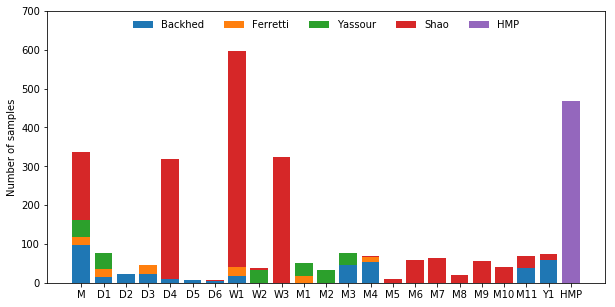

In [76]:
# Supplemental Figure S1

fig, ax = plt.subplots(figsize=(10, 5))

# mi_tp_binned_labels.remove('6 day')


cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
tp_labels = ['Mother'] + mi_tp_binned_labels[1:] + ['HMP']
tp_labels_abbreviated = ['M'] + [(label.split(' ')[1][0].upper() + label.split(' ')[0]) for label in mi_tp_binned_labels[1:]] + ['HMP']

bin_counts_per_cohort = {cohort: np.zeros(len(tp_labels)) for cohort in cohorts}

for sample in mother_samples: # mother_samples should already not include Yassour +/- 3 months
    cohort = sample_cohort_map[sample]
    bin_counts_per_cohort[cohort][0] += 1

for infant_tp_bin, idx in zip(mi_tp_binned_labels[1:], np.arange(1, 1+len(mi_tp_binned_labels[1:]))):
    
    if infant_tp_bin == '1 day': # Merge birth and 1 day into 1 day
        for sample in mi_tp_sample_dict_binned['infant']['birth']:
            cohort = sample_cohort_map[sample]
            bin_counts_per_cohort[cohort][idx] += 1
    
    for sample in mi_tp_sample_dict_binned['infant'][infant_tp_bin]:
        cohort = sample_cohort_map[sample]
        bin_counts_per_cohort[cohort][idx] += 1

for sample in hmp_samples:
    cohort = sample_cohort_map[sample]
    bin_counts_per_cohort[cohort][1+len(mi_tp_binned_labels[1:])] += 1

indices = np.arange(len(tp_labels))    

acc = np.zeros(len(tp_labels))
for cohort in cohorts:
    cohort_label = 'HMP' if cohort == 'hmp' else cohort.capitalize()
    ax.bar(indices, bin_counts_per_cohort[cohort], label=cohort_label, bottom=acc)
    acc += bin_counts_per_cohort[cohort]

ax.set_ylabel("Number of samples")
# ax.set_yscale('log')
ax.set_xticks(indices)
ax.set_xticklabels(tp_labels_abbreviated)

ax.set_ylim((0, 700))
ax.legend(frameon=False, loc='upper center', ncol=len(cohorts))

plt.show()
fig.savefig('%s/samples_by_tp_cohorts.pdf' % (config.analysis_directory),bbox_inches='tight')
fig.savefig('%s/samples_by_tp_cohorts.png' % (config.analysis_directory),bbox_inches='tight', dpi=500)

In [8]:
# Set up data and custom bins for metadata overview figure

custom_bins = ['Mother', 'Birth\n(meconium)', 'Day 1', 'Day 3-4', 'Day 6', 
               'Week 1', 'Week 2', 'Week 3', 'Month 1', 'Month 2', 'Month 3', 
               'Month 4', 'Month 12', 'Month 4-14']
custom_infant_bins = custom_bins[1:]
custom_bin_defs = {'Mother': (-100, 100), 'Birth\n(meconium)': (0, 0), 'Day 1': (1, 1), 'Day 3-4': (3,4), 'Day 6': (6,6),
                  'Week 1': (7, 13), 'Week 2': (14, 20), 'Week 3': (21, 21), 'Month 1': (30, 31), 'Month 2': (60, 62),
                  'Month 3': (91, 93), 'Month 4': (122, 122), 'Month 12': (366, 366), 'Month 4-14': (124, 440)}

def get_infant_tp_bin(tp, custom_infant_bins, custom_bin_defs):
    for bin_label in custom_infant_bins:
        start, end = custom_bin_defs[bin_label]
        if tp >= start and tp <= end:
            return bin_label
    return str(tp)

timepoints_by_cohort = {cohort: [] for cohort in mi_cohorts}
subject_ids_by_cohort = {cohort: [] for cohort in mi_cohorts}
all_timepoints = set()

custom_bins_by_cohort = {cohort: [] for cohort in mi_cohorts}

i = 0
for subject in subject_sample_map:
    for sample in subject_sample_map[subject]:        
        if sample not in mi_samples_no_olm:
            continue
        cohort = sample_cohort_map[sample]
        day = mi_sample_day_dict[sample]
        
        if sample in mother_samples:
            if not (day >= 0 and day <= 7): # ignore other mom timepoints here
                continue
            custom_bin = 'Mother'
        else:
            custom_bin = get_infant_tp_bin(day, custom_infant_bins, custom_bin_defs)
        custom_bins_by_cohort[cohort].append(custom_bin)
        
        timepoints_by_cohort[cohort].append(day)
        subject_ids_by_cohort[cohort].append(i)
        
        all_timepoints.add(day)
    i += 1

# Custom tweak to Shao
custom_bins_by_cohort['shao'].remove('Month 12')

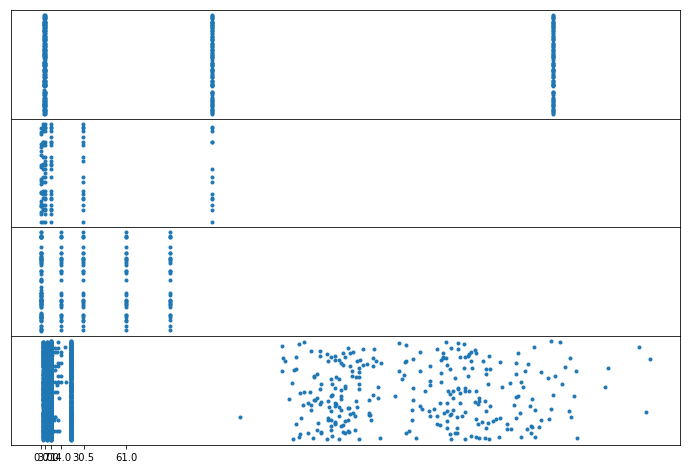

In [13]:
# Show distribution of timepoints per subject by cohorts

fig, ax = plt.subplots(4, 1, figsize=(12,8), sharex=True, gridspec_kw={'wspace':0.025, 'hspace':0})

cohort_i = 0
for cohort in mi_cohorts:
    timepoints = timepoints_by_cohort[cohort]
    subject_ids = subject_ids_by_cohort[cohort]
    ax[cohort_i].set_yticks([])
    ax[cohort_i].set_xticks([0, 3, 7, 14, 30.5, 61])
    # ax[cohort_i].set_xticklabels(['Birth\n(meconium)'])
    ax[cohort_i].plot(timepoints, subject_ids, '.')
    
    cohort_i += 1

plt.show()

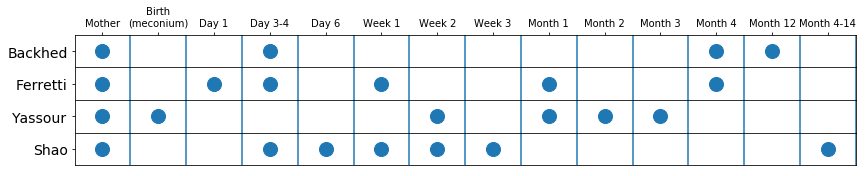

In [14]:
# Show timepoints by cohort
fig, ax = plt.subplots(4, 1, figsize=(14,2.4), gridspec_kw={'wspace':0.025, 'hspace':0})

mi_cohort_labels = []

cohort_i = 0
for cohort in mi_cohorts:
    custom_bin_idxs = []
    for custom_bin in set(custom_bins_by_cohort[cohort]):
        custom_bin_idxs.append(custom_bins.index(custom_bin))
    ax[cohort_i].set_xlim((-0.5, len(custom_bins)-0.5))
    ax[cohort_i].plot(custom_bin_idxs, [cohort_i]*len(custom_bin_idxs), 'o', markersize=14)    
    ax[cohort_i].set_yticks([cohort_i])
    ax[cohort_i].set_yticklabels([cohort.capitalize()], fontsize=14)
    ax[cohort_i].set_xticks([])
    for x in np.arange(0.5, len(custom_bins), step=1):
        ax[cohort_i].axvline(x=x)
    cohort_i += 1

ax[0].set_xticks(np.arange(len(custom_bins)))
ax[0].set_xticklabels(custom_bins)
ax[0].xaxis.tick_top()

plt.tick_params(top=False)
fig.savefig('%s/cohort_timepoints_v1.pdf' % (config.analysis_directory),bbox_inches='tight')
plt.show()

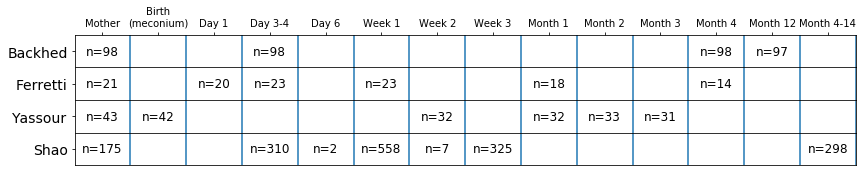

In [15]:
# Alternate: include numbers of samples per timepoint-cohort pair
fig, ax = plt.subplots(4, 1, figsize=(14,2.4), gridspec_kw={'wspace':0.025, 'hspace':0})

mi_cohort_labels = []
for cohort in mi_cohorts:
    mi_cohort_labels.append('%s\n%i subjects')

cohort_i = 0
for cohort in mi_cohorts:
    custom_bin_idxs = []
    for custom_bin in set(custom_bins_by_cohort[cohort]):
        custom_bin_idxs.append(custom_bins.index(custom_bin))
    ax[cohort_i].set_xlim((-0.5, len(custom_bins)-0.5))
    for custom_bin_idx in custom_bin_idxs:
        custom_bin = custom_bins[custom_bin_idx]        
        ax[cohort_i].text(custom_bin_idx, 0.5, 'n=%i' % (custom_bins_by_cohort[cohort].count(custom_bin)), 
                          ha='center', va='center', fontsize=12)
    ax[cohort_i].set_yticks([0.5])
    ax[cohort_i].set_yticklabels([cohort.capitalize()], fontsize=14)
    ax[cohort_i].set_xticks([])
    for x in np.arange(0.5, len(custom_bins), step=1):
        ax[cohort_i].axvline(x=x)
    cohort_i += 1

ax[0].set_xticks(np.arange(len(custom_bins)))
ax[0].set_xticklabels(custom_bins)
ax[0].xaxis.tick_top()

plt.tick_params(top=False)
fig.savefig('%s/cohort_timepoints_v2.pdf' % (config.analysis_directory),bbox_inches='tight')
plt.show()